It is assumed that there are some latent features on our likes. For instance, for a movie case, the genre, the actors, the hue, even the hour watched may be the reason for one's like. Moreover, these features correspond with the movie as well. Both, the user features and the movie features have weights in different scalars. 

For the matrices composing of user features and movie features respectively, it is assumed that the dot products of the features form up the user rating matrice. 

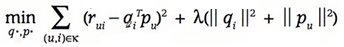

This is the loss function. Let rui be the user rate, qi item and pu user feature weights. Since the dot product of qi and pu give the user rate, the difference between their product and the real rate value, i.e the error should be minimum. The aim is to find these p and q values that will give the minimum value of sum of squared errors. These values are calculated by Gradient Descent. 

After finding p and q, the missing rate values are calculated. 

In this project, it is aimed to find missing anime ratings of users by matrix factorization. The Anime Recommendations Database will be used.


In [1]:
import numpy as np 
import pandas as pd 

/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


In [2]:
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
pd.set_option('display.max_columns', None)

In [3]:
df1 = pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv")
df2 = pd.read_csv("/kaggle/input/anime-recommendations-database/rating.csv")

In [4]:
df1.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
df2.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
# Two datasets are merged, so the animes, the users and their ratings are gathered in one dataframe. Here rating_x is overall
# rating whereas rating_y is the rating of the user. 
df = df1.merge(df2, how= "left", on="anime_id")
df.tail()
#rating_x: overall rating, rating_y user's rating

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
7814819,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532.0,-1.0
7814820,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766.0,-1.0
7814821,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365.0,4.0
7814822,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364.0,-1.0
7814823,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,48766.0,-1.0


In [7]:
df.shape

(7814824, 9)

In [8]:
# Only a few animes will be chosen, so the dataframe is ordered to get the most voted animes.
df1.sort_values("members",ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796


In [9]:
#The animes with the most ratings are chosen.
anime_ids = [1535,16498, 11757, 5114]

In [10]:
# A subset dataframe including only chosen anime ids.
sample_df = df[df.anime_id.isin(anime_ids)]

In [11]:
sample_df.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
2199,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3.0,10.0
2200,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,10.0,10.0
2201,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,11.0,8.0
2202,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,12.0,9.0
2203,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,17.0,10.0


In [12]:
# A user - anime pivot table is constructed to apply matrix factorization. 
user_anime_df = sample_df.pivot_table(index=["user_id"], columns=["name"], values="rating_y")
user_anime_df.head()

name,Death Note,Fullmetal Alchemist: Brotherhood,Shingeki no Kyojin,Sword Art Online
user_id,,,,
1.0,NaN,NaN,-1.0,10.0
3.0,10.0,10.0,10.0,9.0
4.0,-1.0,NaN,-1.0,-1.0
5.0,4.0,NaN,NaN,1.0
6.0,-1.0,NaN,NaN,NaN


In [13]:
sample_df["rating_y"].describe()

count    124081.000000
mean          7.421273
std           3.571178
min          -1.000000
25%           7.000000
50%           9.000000
75%          10.000000
max          10.000000
Name: rating_y, dtype: float64

In [14]:
reader = Reader(rating_scale=(-1, 10))

In [15]:
data = Dataset.load_from_df(sample_df[['user_id', 'anime_id', 'rating_y']], reader)

In [16]:
trainset, testset = train_test_split(data, test_size=.25)

svd_model = SVD()
svd_model.fit(trainset)

predictions = svd_model.test(testset)

In [17]:
len(predictions)

31021

In [18]:
predictions[0:10]

[Prediction(uid=64832.0, iid=5114, r_ui=10.0, est=9.040382340620763, details={'was_impossible': False}),
 Prediction(uid=44266.0, iid=1535, r_ui=10.0, est=9.768120912053956, details={'was_impossible': False}),
 Prediction(uid=31655.0, iid=11757, r_ui=8.0, est=8.272442495361345, details={'was_impossible': False}),
 Prediction(uid=69093.0, iid=1535, r_ui=9.0, est=7.760051558324688, details={'was_impossible': False}),
 Prediction(uid=9101.0, iid=11757, r_ui=10.0, est=8.77046324112498, details={'was_impossible': False}),
 Prediction(uid=43894.0, iid=16498, r_ui=9.0, est=7.904658881963645, details={'was_impossible': False}),
 Prediction(uid=16626.0, iid=16498, r_ui=10.0, est=8.095901943801472, details={'was_impossible': False}),
 Prediction(uid=49158.0, iid=5114, r_ui=10.0, est=8.348116605045437, details={'was_impossible': False}),
 Prediction(uid=36085.0, iid=16498, r_ui=10.0, est=9.537745405599116, details={'was_impossible': False}),
 Prediction(uid=63199.0, iid=1535, r_ui=10.0, est=8.942

In [19]:
accuracy.rmse(predictions)

RMSE: 2.8132


2.8131712900173262

In [20]:
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'test_rmse': array([2.8115378 , 2.81347364, 2.77780906, 2.83133617, 2.82076182]),
 'test_mae': array([1.89037266, 1.89676423, 1.85182017, 1.89359531, 1.90321941]),
 'fit_time': (7.806197881698608,
  7.691082954406738,
  7.664601802825928,
  7.861227750778198,
  7.848590135574341),
 'test_time': (0.20250415802001953,
  0.18892216682434082,
  0.20779752731323242,
  0.48876309394836426,
  0.19404864311218262)}

In [21]:
svd_model.predict(uid=1.0, iid=1535, verbose=True)

user: 1.0        item: 1535       r_ui = None   est = 8.82   {'was_impossible': False}


Prediction(uid=1.0, iid=1535, r_ui=None, est=8.824880918633939, details={'was_impossible': False})

In [22]:
svd_model.predict(uid=1.0, iid=5114, verbose=True)

user: 1.0        item: 5114       r_ui = None   est = 10.00   {'was_impossible': False}


Prediction(uid=1.0, iid=5114, r_ui=None, est=10, details={'was_impossible': False})

In [23]:
# Cross validation is applied to get lower error values. Then the parameters of this best result is used for fitting the model. 

param_grid = {'n_epochs': [50, 100], 'lr_all': [0.005, 0.009]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=-1, joblib_verbose=True)

gs.fit(data)

gs.best_score['rmse']




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.2min finished


2.7278762754446566

In [24]:
gs.best_params['rmse']

{'n_epochs': 100, 'lr_all': 0.009}

In [25]:
gs.best_estimator["rmse"]

In [26]:
svd_model = gs.best_estimator["rmse"]
svd_model.fit(data.build_full_trainset())

In [27]:
# The rates of the users with id 1 and 3 will be predicted. Their rates are as following.
user_anime_df.head(2)

name,Death Note,Fullmetal Alchemist: Brotherhood,Shingeki no Kyojin,Sword Art Online
user_id,,,,
1.0,NaN,NaN,-1.0,10.0
3.0,10.0,10.0,10.0,9.0


In [28]:
df1.loc[df1["anime_id"] == 1535]["name"]

40    Death Note
Name: name, dtype: object

In [29]:
# The user 1.0 did not vote for Death Note, the rating is predicted.
svd_model.predict(uid=1.0, iid=1535, verbose=True)

user: 1.0        item: 1535       r_ui = None   est = 4.86   {'was_impossible': False}


Prediction(uid=1.0, iid=1535, r_ui=None, est=4.858005235000653, details={'was_impossible': False})

In [30]:
df1.loc[df1["anime_id"] == 5114]["name"]

1    Fullmetal Alchemist: Brotherhood
Name: name, dtype: object

In [31]:
# The user 1.0 did not vote for Fullmetal Alchemist either, the rating is predicted.
svd_model.predict(uid=1.0, iid=5114, verbose=True)

user: 1.0        item: 5114       r_ui = None   est = 7.56   {'was_impossible': False}


Prediction(uid=1.0, iid=5114, r_ui=None, est=7.564474382959563, details={'was_impossible': False})

In [32]:
df1.loc[df1["anime_id"] == 16498]["name"]

86    Shingeki no Kyojin
Name: name, dtype: object

In [33]:
# The actual rating of the user 1.0 for Shingeki no Kyojin is -1, so is the predicted rating.
svd_model.predict(uid=1.0, iid=16498, verbose=True)

user: 1.0        item: 16498      r_ui = None   est = -1.00   {'was_impossible': False}


Prediction(uid=1.0, iid=16498, r_ui=None, est=-1, details={'was_impossible': False})

In [34]:
df1.loc[df1["anime_id"] == 11757]["name"]

804    Sword Art Online
Name: name, dtype: object

In [35]:
# The actual rating of the user 1.0 for Sword Art Online is 10.0, the predicted rating is 9.0.
svd_model.predict(uid=1.0, iid= 11757, verbose=True)

user: 1.0        item: 11757      r_ui = None   est = 8.71   {'was_impossible': False}


Prediction(uid=1.0, iid=11757, r_ui=None, est=8.708323563260484, details={'was_impossible': False})

In [36]:
# The actual rating of the user 3.0 for Death Note is 10.0, the predicted rating is 9.97.
svd_model.predict(uid=3.0, iid=1535, verbose=True)

user: 3.0        item: 1535       r_ui = None   est = 9.97   {'was_impossible': False}


Prediction(uid=3.0, iid=1535, r_ui=None, est=9.972713369456272, details={'was_impossible': False})

In [37]:
# The actual rating of the user 3.0 for Fullmetal Alchemist is 10.0, the predicted rating is 9.97.
svd_model.predict(uid=3.0, iid=5114, verbose=True)

user: 3.0        item: 5114       r_ui = None   est = 9.96   {'was_impossible': False}


Prediction(uid=3.0, iid=5114, r_ui=None, est=9.955753204695942, details={'was_impossible': False})

In [38]:
# The actual rating of the user 3.0 for Shingeki no Kyojin is 10.0, the predicted rating is 9.96.
svd_model.predict(uid=3.0, iid=16498, verbose=True)

user: 3.0        item: 16498      r_ui = None   est = 9.96   {'was_impossible': False}


Prediction(uid=3.0, iid=16498, r_ui=None, est=9.95980490065812, details={'was_impossible': False})

In [39]:
# The actual rating of the user 3.0 for Sword Art Online is 9.0, the predicted rating is 9.00 as well.
svd_model.predict(uid=1.0, iid= 11757, verbose=True)

user: 1.0        item: 11757      r_ui = None   est = 8.71   {'was_impossible': False}


Prediction(uid=1.0, iid=11757, r_ui=None, est=8.708323563260484, details={'was_impossible': False})